# <center> Assignment 3 – Convolutional Neural Networks using keras
# <center> Submitted By: Haridas Das

::# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255. # normalize the data by dividing the max of image pixel
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

170498071/170498071 [==============================] - 14s 0us/step


This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes **('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')** for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

In [ ]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.relu): # actual was activation=tf.nn.tanh
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25) # droping out neurons  
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')
                     # Finally dense layer with 10 outputs layer
    def call(self, inputs):

        x = self.conv_1(inputs) # this is the input of the fisrt layer 
        x = self.conv_2(x) # the previous input is the input of the of this layer 
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [ ]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [ ]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 159s 2s/step - loss: 1.8226 - accuracy: 0.3370
Epoch 2/3
98/98 [==============================] - 156s 2s/step - loss: 1.4736 - accuracy: 0.4723
Epoch 3/3
98/98 [==============================] - 155s 2s/step - loss: 1.3463 - accuracy: 0.5195


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

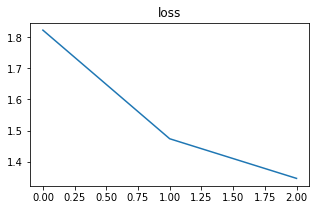

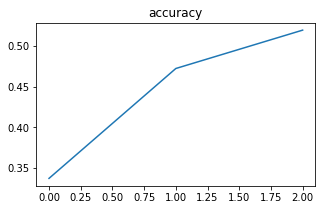

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [ ]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 10s - loss: 1.1721 - accuracy: 0.5941 - 10s/epoch - 31ms/step
accuracy: 59.41%
CPU times: user 14.9 s, sys: 287 ms, total: 15.2 s
Wall time: 9.81 s


We can also again check the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 9s 28ms/step
[[710  39  78  15  12   7  24  13  64  38]
 [ 34 794  10   3   6   3  20  10  22  98]
 [ 81  17 474  50  98  71 115  64  17  13]
 [ 22  17 117 299  64 231 169  51   9  21]
 [ 40   9 157  33 441  50 144 115   8   3]
 [ 17   6 111 111  46 525  74  91  11   8]
 [  5   9  58  28  59  20 784  21   4  12]
 [ 22   5  37  35  55  83  45 689   3  26]
 [162  88  23  12   6  15  19  10 616  49]
 [ 49 204   8   6   6   7  35  39  37 609]]

Classification accuracy for each class:

0: 0.7100
1: 0.7940
2: 0.4740
3: 0.2990
4: 0.4410
5: 0.5250
6: 0.7840
7: 0.6890
8: 0.6160
9: 0.6090


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [ ]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [ ]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [ ]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [ ]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
took 38.9 seconds for epoch #0
beginning epoch 1
took 39.8 seconds for epoch #1
beginning epoch 2
took 39.0 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.06%, although it varies randomly.

In [8]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.relu): # activation=tf.nn.relu provides support for the ReLU in Tensorflow. 
        tf.keras.models.Model.__init__(self)   # change tanh to relu  

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.2)
        self.conv_5 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_6 = tf.keras.layers.Conv2D(256, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_8 = tf.keras.layers.Dropout(0.2)
        self.conv_9 = tf.keras.layers.Conv2D(512, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_10 = tf.keras.layers.Conv2D(1024, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_11 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_12 = tf.keras.layers.Dropout(0.2)
        self.dense_13 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_14 = tf.keras.layers.Dropout(0.2)
        self.dense_15 = tf.keras.layers.Dense(10, activation='softmax')
        

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.pool_7(x)
        x = self.drop_8(x)
        
        
        x = self.conv_9(x)
        x = self.conv_10(x)
        x = self.pool_11(x)
        x = self.drop_12(x)
        
        
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_13(x)
        x = self.drop_14(x)
        x = self.dense_15(x)

        return x

In [9]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [10]:
batch_size = 50 
epochs = 10 # the epoch is 10 good
lr = 0.001  # chage the learning rate 
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/10
1000/1000 [==============================] - 28s 26ms/step - loss: 1.7439 - accuracy: 0.3695
Epoch 2/10
1000/1000 [==============================] - 27s 27ms/step - loss: 1.1498 - accuracy: 0.5923
Epoch 3/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.9174 - accuracy: 0.6831
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.7694 - accuracy: 0.7361
Epoch 5/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.6730 - accuracy: 0.7687
Epoch 6/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.5948 - accuracy: 0.7964
Epoch 7/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5260 - accuracy: 0.8192
Epoch 8/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4784 - accuracy: 0.8358
Epoch 9/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.4368 - accuracy: 0.8498
Epoch 10/10
1000/1000 [==============================] - 27s 27m

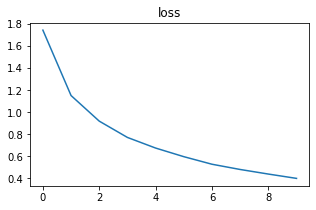

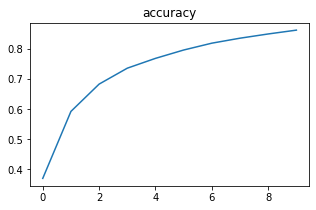

In [11]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [12]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 2s - loss: 0.6208 - accuracy: 0.8103 - 2s/epoch - 8ms/step
accuracy: 81.03%
CPU times: user 1.74 s, sys: 149 ms, total: 1.88 s
Wall time: 2.61 s


# Case 1: 

In the model, first, I changed activation=tf.nn.relu instead of activation=tf.nn.tan. There may not be a huge impact. Then, I changed the Con2D filter by 32, 64,128,256,512,512, Dense layer 128, and Dense layer 10 to classify ten outputs. In between, I used MaxPooling layer two by two and dropped out the neurons randomly (0.2) using the Dropout command. This gives us a training accuracy of 0.8717 and a test accuracy of 0.8134, which is 81.34%. The classification accuracy increased from 58.06% to 81.34%.

# Case 2: 

In the model, first, I changed activation=tf.nn.relu instead of activation=tf.nn.tan. There may not be a huge impact. Then, I changed the Con2D filter by 32, 64,128,256,512,1024, Dense layer 128, and Dense layer 10 to classify ten outputs. In between, I used MaxPooling layer two by two and dropped out the neurons randomly (0.2) using the Dropout command. This gives us a training accuracy of 0.86.26 and a test accuracy of 0.8103, which is 81.03%. The classification accuracy is increased from 58.06% to 81.03%

# Conclusion: 
The classification accuracy is almost the same in both cases. Changing layers and modifying the model by increasing layers contribute more parameters, but both models' accuracy is still the same. By this comparison, we can even increase the accuracy by almost close to 99% by changing epochs, batch size, and learning rate. 